Index([' Label', ' Destination Port', 'Total Length of Fwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Mean',
       ' Fwd Header Length', ' Avg Fwd Segment Size', ' Subflow Fwd Bytes',
       'Init_Win_bytes_forward', ' act_data_pkt_fwd'],
      dtype='object')
Number of anomalies in the test set: 26705
              precision    recall  f1-score   support

           0       0.74      0.87      0.80    203080
           1       0.04      0.01      0.02     64165

    accuracy                           0.67    267245
   macro avg       0.39      0.44      0.41    267245
weighted avg       0.57      0.67      0.61    267245



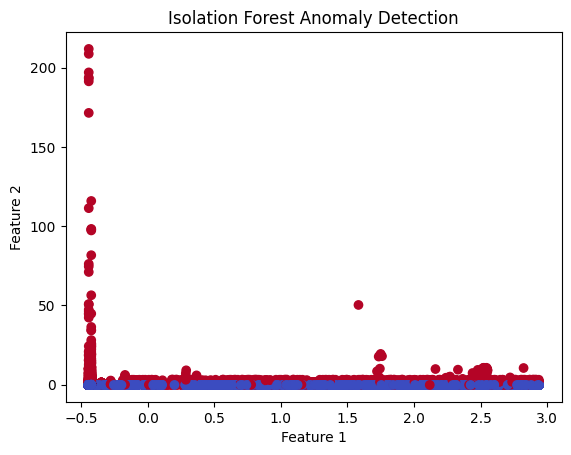

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = pd.read_parquet('./IDS2017/Final/DDoS_Attacks.parquet')
print(data.columns)

# Drop the label column
# Assuming 'Label' is your target variable and it's a column in your data
y = data[' Label']
X = data.drop(' Label', axis=1)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the Isolation Forest model with adjusted hyperparameters
iso_forest = IsolationForest(
    n_estimators=100,  # liczba drzew
    max_samples='auto',  # liczba próbek do wyboru z każdego drzewa
    contamination=0.1,  # oczekiwany procent anomalii
    max_features=1.0,  # liczba cech do losowania dla każdego drzewa
    random_state=42
)

# Train the model
iso_forest.fit(X_train)

# Predictions: -1 for anomalies and 1 for normal instances
y_train_pred = iso_forest.predict(X_train)
y_test_pred = iso_forest.predict(X_test)

# Convert predictions to 0 for normal and 1 for anomalies for easier interpretation
y_train_pred = np.where(y_train_pred == -1, 1, 0)
y_test_pred = np.where(y_test_pred == -1, 1, 0)

# Calculate the number of anomalies in the test set
n_anomalies_test = np.sum(y_test_pred)
print(f"Number of anomalies in the test set: {n_anomalies_test}")

# Map 'ATTACK' to 1 and 'BENIGN' to 0
y_train = y_train.map({'ATTACK': 1, 'BENIGN': 0})
y_test = y_test.map({'ATTACK': 1, 'BENIGN': 0})

# Now you can calculate and print the classification report
print(classification_report(y_test, y_test_pred))



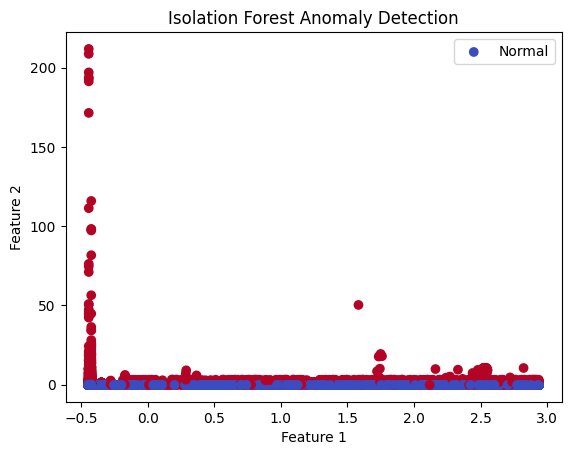

In [7]:
# wizualizacja
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test_pred, cmap='coolwarm')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(['Normal', 'Anomaly'])
plt.title('Isolation Forest Anomaly Detection')
plt.show()
